<a href="https://colab.research.google.com/github/sayakpaul/A-Barebones-Image-Retrieval-System/blob/master/Similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup and imports

In [1]:
!pip install -q tf-nightly

     |████████████████████████████████| 323.7MB 46kB/s 
     |████████████████████████████████| 6.7MB 49.7MB/s 
     |████████████████████████████████| 460kB 55.5MB/s 


In [2]:
!pip install -q tfds-nightly

     |████████████████████████████████| 3.4MB 5.5MB/s 
     |████████████████████████████████| 296kB 45.6MB/s 


In [3]:
from google.colab import auth as google_auth
google_auth.authenticate_user()

In [4]:
!gsutil ls -lh gs://image-retrieval-system/

 61.18 MiB  2020-07-30T02:08:44Z  gs://image-retrieval-system/facenet_like_model.h5
 61.18 MiB  2020-07-30T02:15:46Z  gs://image-retrieval-system/facenet_like_model_less_data.h5
 19.83 MiB  2020-07-30T02:19:26Z  gs://image-retrieval-system/facenet_like_model_less_data_mbnetv2.h5
 19.83 MiB  2020-07-30T02:36:45Z  gs://image-retrieval-system/facenet_like_model_less_data_mbnetv2_da.h5
171.57 MiB  2020-07-29T14:45:20Z  gs://image-retrieval-system/full_length_flower_classifier.h5
TOTAL: 5 objects, 349788400 bytes (333.58 MiB)


In [5]:
!gsutil -m cp -r gs://image-retrieval-system/*.h5 .

Copying gs://image-retrieval-system/facenet_like_model.h5...
Copying gs://image-retrieval-system/facenet_like_model_less_data.h5...
Copying gs://image-retrieval-system/facenet_like_model_less_data_mbnetv2.h5...
Copying gs://image-retrieval-system/facenet_like_model_less_data_mbnetv2_da.h5...
Copying gs://image-retrieval-system/full_length_flower_classifier.h5...
- [5/5 files][333.6 MiB/333.6 MiB] 100% Done                                    
Operation completed over 5 objects/333.6 MiB.                                    


In [1]:
import tensorflow as tf
print(tf.__version__)

2.4.0-dev20200731


In [32]:
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from tensorflow.keras.applications import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import matplotlib.pyplot as plt
import numpy as np
import time

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [3]:
# Fix the random seeds
np.random.seed(666)
tf.random.set_seed(666)

## Flowers dataset (validation dataset only)

In [4]:
# Gather Flowers dataset
_, validation_ds = tfds.load(
    "tf_flowers",
    split=["train[:85%]", "train[85%:]"],
    as_supervised=True
)

In [19]:
CLASSES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [5]:
print(len(validation_ds))

550


## Dataset preparation

In [6]:
# Image resize
size = (224, 224)

validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))

In [7]:
# Other preprocessing utils
def scale_img(img, label):
    img = tf.cast(img, tf.float32) / 255.
    return (img, label)

# Construct the batched dataset
batch_size = 64
AUTO = tf.data.experimental.AUTOTUNE

validation_ds = validation_ds.map(scale_img, num_parallel_calls=AUTO).\
    batch(batch_size).\
    prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

## Prepare the feature extractor model

Here we are using the fully supervised model trained on the full training dataset. 

In [8]:
supervised_model = load_model("full_length_flower_classifier.h5")
supervised_model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [9]:
feature_extractor = Model(supervised_model.input, supervised_model.layers[-4].output)
feature_extractor.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

## Operating on a single batch for verification

In [23]:
images, labels = next(iter(validation_ds.take(1)))
print(images.shape, labels.shape)

(64, 224, 224, 3) (64,)


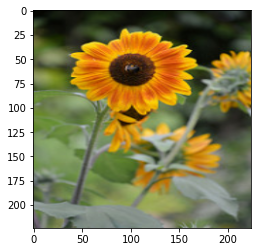

In [24]:
# Select an image randomly from this batch
# This is going to be our query image
random_index = int(np.random.choice(images.shape[0], 1))
plt.imshow(images[random_index])
plt.show()

## Train a nearest neighbors' model

In [25]:
# Finding out nearest neighbors for the features of our query image
validation_features = feature_extractor.predict(images)
start = time.time()
neighbors = NearestNeighbors(n_neighbors=5,
    algorithm='brute',
    metric='euclidean').fit(validation_features)
print('Time taken: {:.5f} secs'.format(time.time() - start))

Time taken: 0.00031 secs


In [26]:
# Determine the neighbors nearest to our query image
distances, indices = neighbors.kneighbors([validation_features[random_index]])
for i in range(5):
    print(distances[0][i])

0.0
13.95395
15.515408
19.246716
19.88504


It's a good practice to project the features extracted to a unit hypersphere i.e. normalize the features when training nearest neighbors' models. 

In [27]:
# Finding out nearest neighbors for the features of our query image
validation_features = feature_extractor.predict(images)
normalized_features = validation_features / np.linalg.norm(validation_features)
start = time.time()
neighbors = NearestNeighbors(n_neighbors=5,
    algorithm='brute',
    metric='euclidean').fit(normalized_features)
print('Time taken: {:.5f} secs'.format(time.time() - start))

Time taken: 0.00038 secs


In [28]:
# Determine the neighbors nearest to our query image
distances, indices = neighbors.kneighbors([normalized_features[random_index]])
for i in range(5):
    print(distances[0][i])

0.0
0.064261705
0.07145264
0.08863632
0.09157597


## Visualize a neighbor 

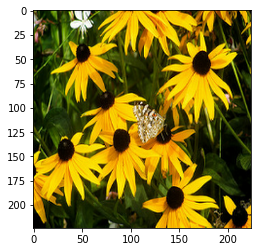

In [29]:
plt.imshow(images[indices[0][1]], interpolation='lanczos')
plt.show()

## Visualizing the nearest neighbors for a few images

In [37]:
def plot_images(images, labels, distances):
    plt.figure(figsize=(20, 10))
    columns = 4
    for (i, image) in enumerate(images):
        ax = plt.subplot(len(images) / columns + 1, columns, i + 1)
        if i == 0:
            ax.set_title("Query Image\n" + "Label: {}".format(CLASSES[labels[i]]))
        else:
            ax.set_title("Similar Image # " + str(i) +
                         "\nDistance: " +
                         str(float("{0:.2f}".format(distances[i]))) + 
                         "\nLabel: {}".format(CLASSES[labels[i]]))
        plt.imshow(image)

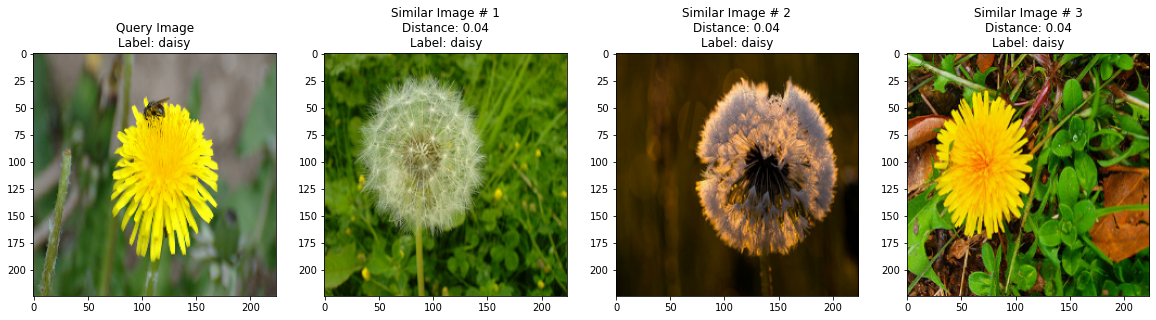

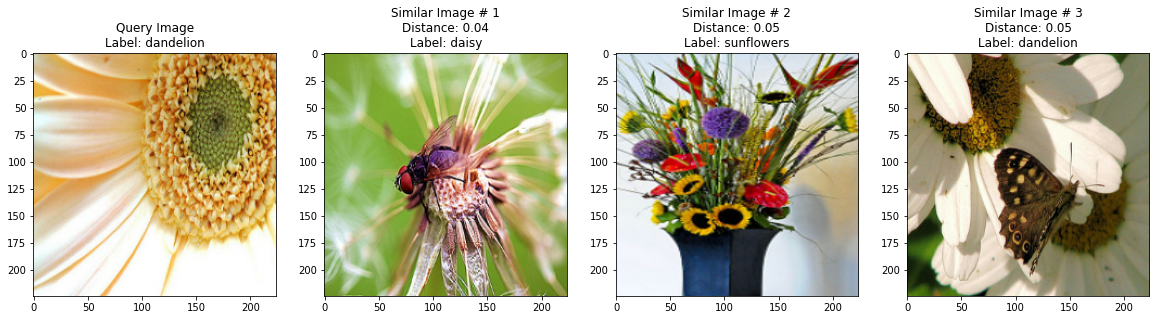

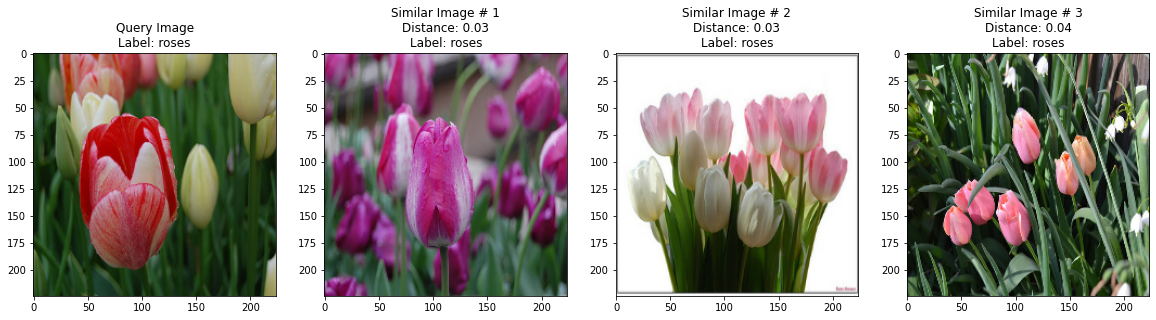

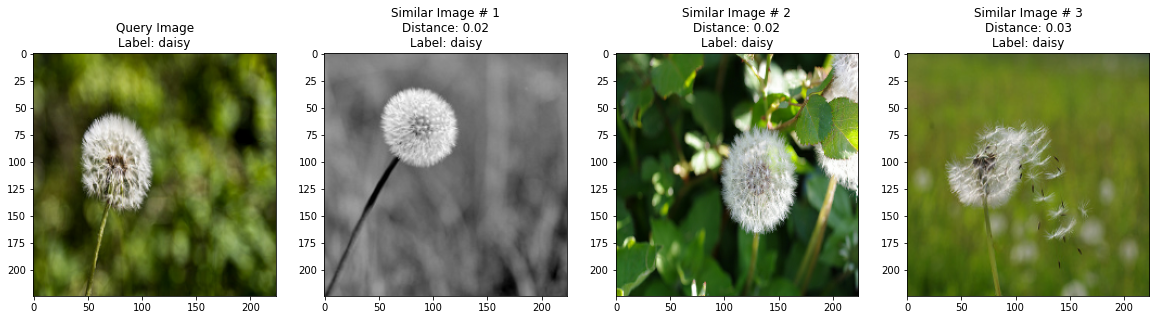

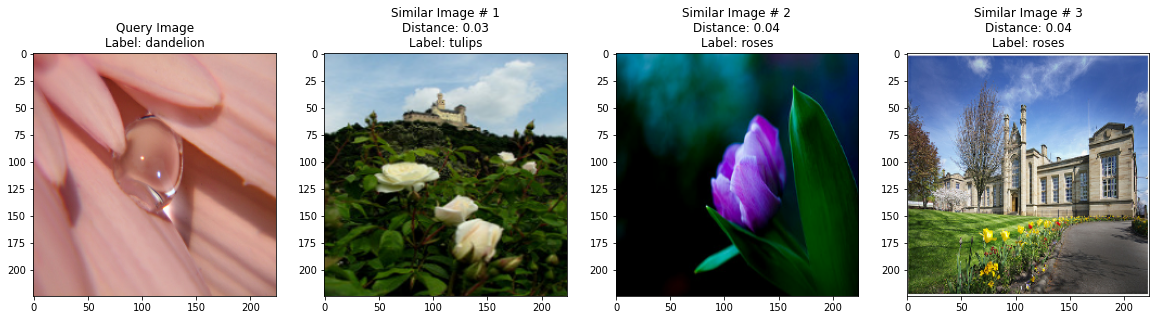

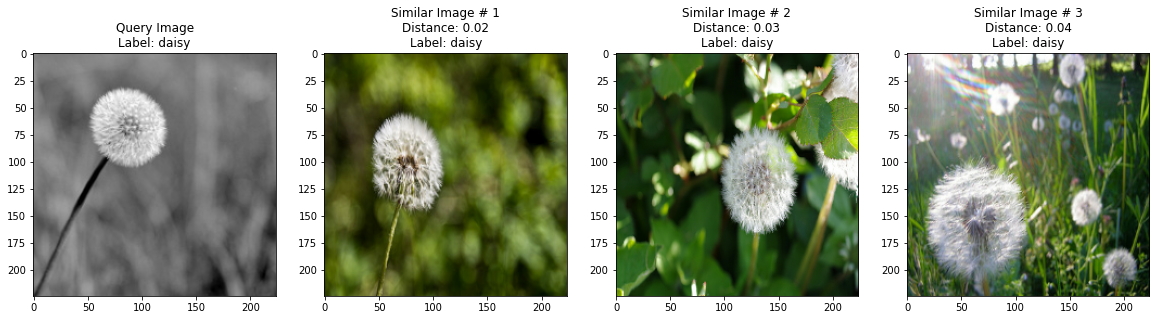

In [38]:
for i in range(6):
    random_index = int(np.random.choice(images.shape[0], 1))
    distances, indices = neighbors.kneighbors(
        [normalized_features[random_index]])
    
    # Don't take the first closest image as it will be the same image
    similar_images = [images[random_index]] + \
        [images[indices[0][i]] for i in range(1, 4)]
    similar_labels = [labels[random_index]] + \
        [labels[indices[0][i]] for i in range(1, 4)]
    plot_images(similar_images, similar_labels, distances[0])

We see some false positives here. 

## Visualizing the embedding space

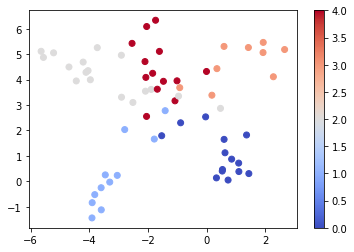

In [34]:
tsne_results = TSNE(n_components=2).fit_transform(normalized_features)

color_map = plt.cm.get_cmap('coolwarm')
scatter_plot = plt.scatter(tsne_results[:, 0],
                           tsne_results[:, 1],
                           c=labels,
                           cmap=color_map)
plt.colorbar(scatter_plot)
plt.show()

## Visually validating the model trained with Triplet Loss

In [41]:
def embedding_model(embedding_dim, pretrained_model):
    inputs = Input(shape=(224, 224, 3))
    features = pretrained_model(inputs, training=False)
    
    x = GlobalAveragePooling2D()(features)
    x = Dense(2048, activation="relu")(x)
    x = Dense(embedding_dim)(x)
    outputs = Lambda(lambda a: tf.math.l2_normalize(a, axis=1))(x)
    
    model = Model(inputs, outputs)

    return model

vgg_16 = tf.keras.applications.VGG16(include_top=False, weights="imagenet",
                                              input_shape=(224, 224, 3))
vgg_16.trainable = False

facenet_like_model = embedding_model(128, vgg_16)
facenet_like_model.load_weights("/content/facenet_like_model.h5")

In [42]:
# Finding out nearest neighbors for query features
validation_features = facenet_like_model.predict(images)
start = time.time()
neighbors = NearestNeighbors(n_neighbors=5,
    algorithm='brute',
    metric='euclidean').fit(validation_features)
print('Time taken: {:.5f} secs'.format(time.time() - start))

Time taken: 0.00036 secs


In [44]:
distances, indices = neighbors.kneighbors([validation_features[random_index]])
for i in range(5):
    print(distances[0][i])

0.0
0.2043671
0.3187638
0.3340198
0.3441273


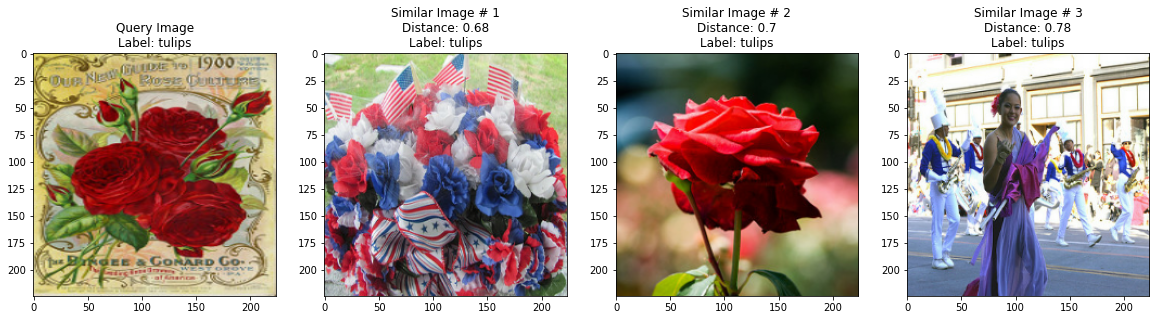

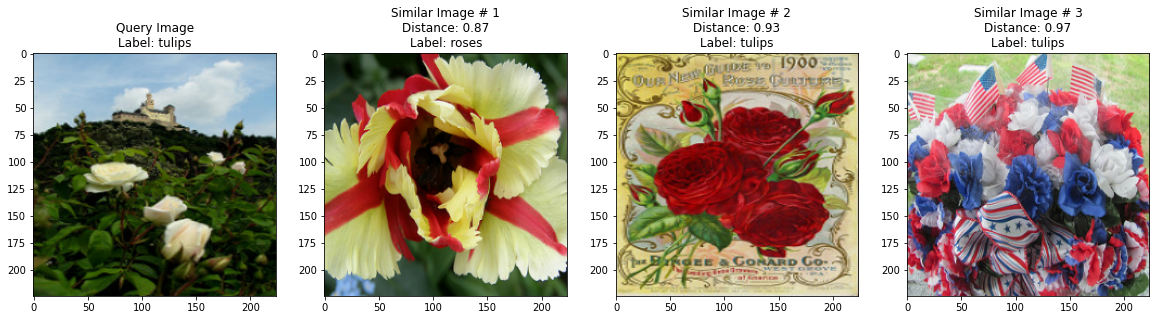

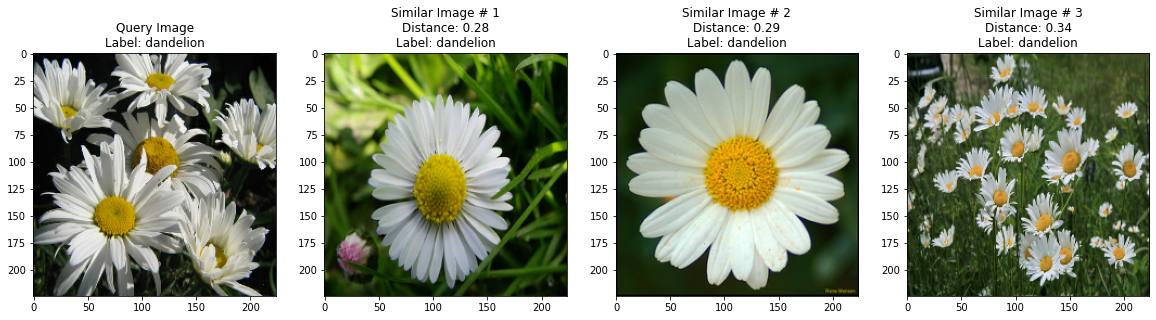

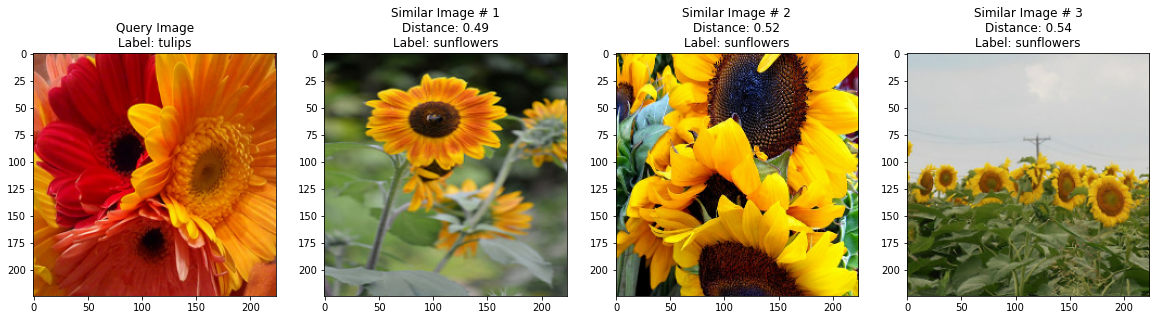

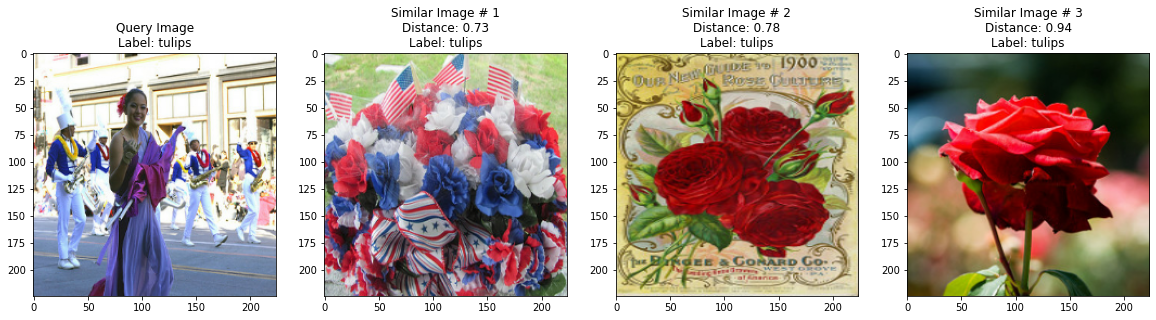

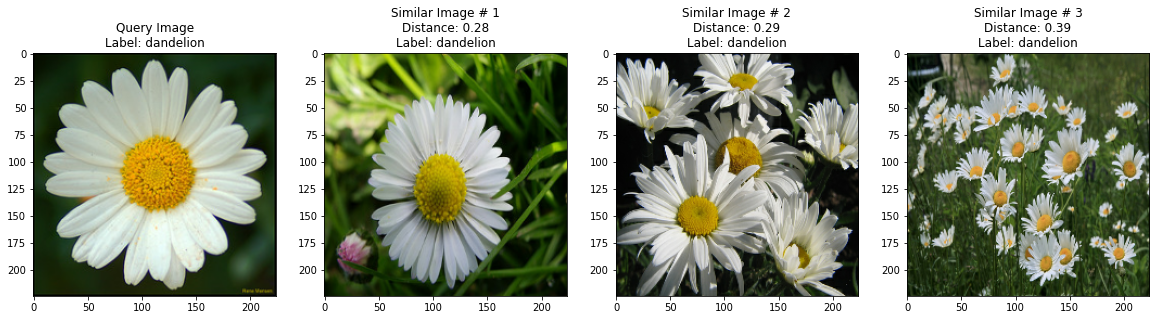

In [45]:
for i in range(6):
    random_index = int(np.random.choice(images.shape[0], 1))
    distances, indices = neighbors.kneighbors(
        [validation_features[random_index]])
    
    # Don't take the first closest image as it will be the same image
    similar_images = [images[random_index]] + \
        [images[indices[0][i]] for i in range(1, 4)]
    similar_labels = [labels[random_index]] + \
        [labels[indices[0][i]] for i in range(1, 4)]
    plot_images(similar_images, similar_labels, distances[0])

False positives exist here too but here is an observation:
- For a tulip, the model picked up a couple of sunflowers (third row from the last). Shape wise and texture wise the samples seem to be similar. Maybe if we discard these confusing examples it would be better for the model.


## Visualizing the embedding space of the model trained with Triplet Loss

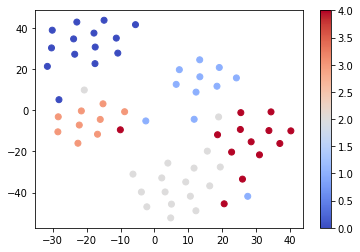

In [46]:
tsne_results = TSNE(n_components=2).fit_transform(validation_features)

color_map = plt.cm.get_cmap('coolwarm')
scatter_plot = plt.scatter(tsne_results[:, 0],
                           tsne_results[:, 1],
                           c=labels,
                           cmap=color_map)
plt.colorbar(scatter_plot)
plt.show()

## Evaluation of the overall clusters formed by these different models

In [49]:
validation_labels = [label
    for _, labels in validation_ds for label in labels
]
print(len(validation_labels))

550


### Regular fully supervised model

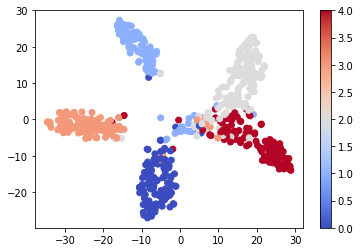

In [50]:
validation_features = feature_extractor.predict(validation_ds)
normalized_features = validation_features / np.linalg.norm(validation_features)

tsne_results = TSNE(n_components=2).fit_transform(normalized_features)

color_map = plt.cm.get_cmap('coolwarm')
scatter_plot = plt.scatter(tsne_results[:, 0],
                           tsne_results[:, 1],
                           c=validation_labels,
                           cmap=color_map)
plt.colorbar(scatter_plot)
plt.show()

### Model trained with Triplet Loss

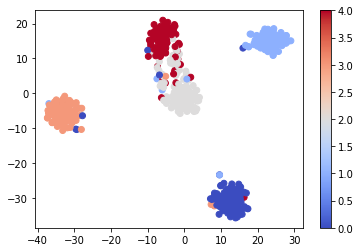

In [51]:
validation_features = facenet_like_model.predict(validation_ds)

tsne_results = TSNE(n_components=2).fit_transform(validation_features)

color_map = plt.cm.get_cmap('coolwarm')
scatter_plot = plt.scatter(tsne_results[:, 0],
                           tsne_results[:, 1],
                           c=validation_labels,
                           cmap=color_map)
plt.colorbar(scatter_plot)
plt.show()

We see overlaps being present in both of the clusters which suggests that there might be confusing examples present in the dataset itself. In the latter case, we see clusters to be more dense. 